In [17]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas
from math import *
from sklearn.metrics import accuracy_score, roc_curve, r2_score
import random

% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 4, 4

# import warnings
# warnings.filterwarnings("ignore")

def read_data(file):
    data = pandas.read_csv(file)
    return data.drop('label', axis=1).as_matrix(), data['label'].as_matrix()

# 1

Функция, обучающая наивный байес по данному распределение

In [2]:
def naive_biase(X_train, y_train, X_test, distr):
    unique_ys, yp = np.unique(y_train, return_counts=True)
    yp = yp / len(y_train)
    ds = [[distr(X_train[y_train == cur_y, i]) for i in range(X_train.shape[1])] for cur_y in unique_ys]
    
    log_probs = np.zeros((X_test.shape[0], 2))
    log_probs += np.log(yp)
    
    for i, cur_y in enumerate(unique_ys):
        for j in range(X_test.shape[1]):
            log_probs[:, i] += ds[i][j].log_predict(X_test[:, j])
    return log_probs[:, 1] - log_probs[:, 0]

Вычисление метрик

In [3]:
def summary(y_true, y_pred):
    print(accuracy_score(y_true, y_pred > 0))
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)    
    plt.plot(fpr, tpr)
    plt.show()

Распределение Гаусса

0.9024125190176049


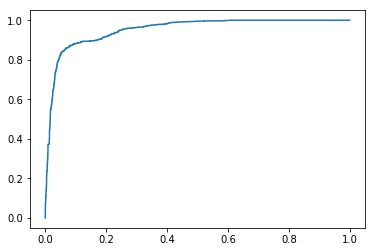

In [4]:
class GaussianDistr:
    def __init__(self, xs):
        self.mean = xs.mean()
        self.std = xs.std()
        
    def log_predict(self, xs):
        return -0.5 * (xs - self.mean)**2 / self.std**2

X, y = read_data('./spambase.csv')
summary(y, naive_biase(X, y, X, GaussianDistr))

Мультиномиальное распределение

0.8491921005385996


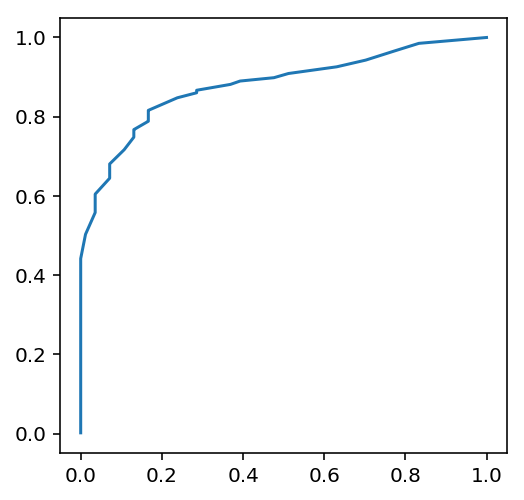

In [37]:
class MultinomialDistr:
    def __init__(self, xs):
        uniques, counts = np.unique(trainX[trainY == y, 0], return_counts=True)
        self.cnts = np.zeros(200)
        self.cnts[uniques] = counts
        
    def log_predict(self, xs):
        return np.log(self.cnts[xs])
    
def read(file='spambase.csv'):
    df = pandas.read_csv(file)

    train = df.sample(frac=0.9)
    test  = df.drop(train.index)

    split = lambda df: (
        df.drop('label', axis=1).as_matrix(),
        df.label.as_matrix())
    global trainX, trainY, testX, testY
    trainX, trainY = split(train)
    testX, testY   = split(test)
    
read('./smsspam.csv')

X = testX
y = testY


y = y == 'ham'
testY = testY == 'ham'
X = np.apply_along_axis(lambda features: [len(set(features[0].split()))], 1, X)
testX = np.apply_along_axis(lambda features: [len(set(features[0].split()))], 1, testX)


unique_ys, yp = np.unique(y_train, return_counts=True)
yp = yp / len(y_train)
ds = [[distr(X_train[y_train == cur_y, i]) for i in range(X_train.shape[1])] for cur_y in unique_ys]

log_probs = np.zeros((X_test.shape[0], 2))
log_probs += np.log(yp)

for i, cur_y in enumerate(unique_ys):
    for j in range(X_test.shape[1]):
        log_probs.T[i] += ds[i][j].log_predict(X_test.T[j])
res = log_probs[:, 1] - log_probs[:, 0]



y_pred = np.nan_to_num(naive_biase(X, y, testX, GaussianDistr))
print(accuracy_score(testY, y_pred > 0))
fpr, tpr, _ = roc_curve(testY, y_pred)    
plt.plot(fpr, tpr)
plt.show()

Распределение Бернулли

0.90328189524


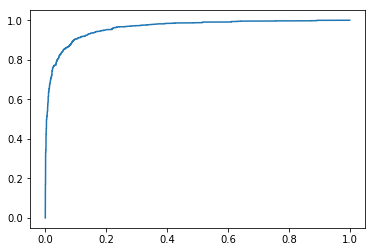

In [6]:
class Bernoulli:
    def __init__(self, xs):
        self.p = xs.sum() / len(xs)

    def log_predict(self, xs):
        return np.log(self.p * xs + (1 - self.p) * (1 - xs))

X, y = read_data('./data/spambase.csv')
X = X > X.mean(axis=0)
summary(y, np.nan_to_num(naive_biase(X, y, X, Bernoulli)))

# 2

Обычная линейная регрессия и ее запуск для noisysine.csv

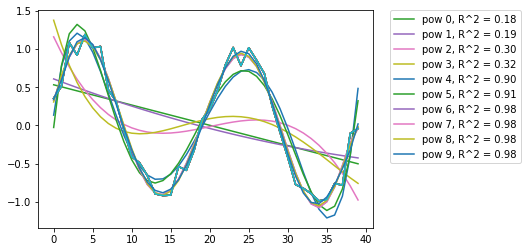

In [7]:
data = pandas.read_csv('./data/noisysine.csv')
X = data['x'].as_matrix()[:, None]
y = data['y'].as_matrix()
plt.plot(X, y)

def regression(X, y, pinv=False):
    X = np.matrix(X)
    y = np.matrix(y[:, None])
    return np.linalg.pinv(X.T * X) * X.T * y if pinv else (X.T * X).I * X.T * y

cur_X = np.ones(X.shape)
for i in range(10):
    cur_X = np.column_stack([cur_X, X * cur_X[:, -1:]])
    w = regression(cur_X, y)

    plt.plot(X, y)
    plt.plot(X, cur_X * w, label='pow {}, R^2 = {:.2f}'.format(i, r2_score(y, cur_X * w)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Обычная линейная регрессия для hydrodynamics.csv

In [8]:
data = pandas.read_csv('./data/hydrodynamics.csv')
X = data.drop('y', axis=1).as_matrix()
y = data['y'].as_matrix()
n, k = X.shape

w = regression(X, y)
print(r2_score(y, X * w))

X = np.column_stack([np.ones((n, 1)), X] + [(X[:, i] * X[:, j])[:, None] for i in range(k) for j in range(k)])
w = regression(X, y, True)
print(r2_score(y, X * w))

0.656991158809
0.930334878623


Так как теперь нужно подбирать параметры, нужна кросс валидация. Я делаю просто LOO. 
Функция leave_one_out делает LOO для переданного ей классификатора
RegressionWrapper переделывает функцию, обучающую регрессию в класс с методами fit, predict

best alpha: 0.07497878525248533, best R^2 score: 0.6413328205463033


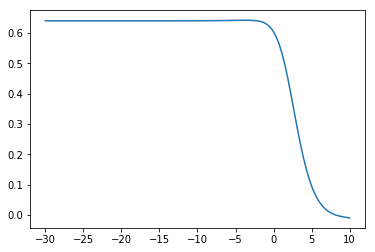

In [9]:
class RegressionWrapper:
    def __init__(self, func, *args, **kwargs):
        self.func = func
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, y):
        self.w = self.func(X, y, *self.args, **self.kwargs)
        return self
    
    def predict(self, X):
        return X.dot(self.w)
        
def leave_one_out(X, y, clf):
    res = np.zeros(y.shape[0])
    
    for i in range(y.shape[0]):
        res[i] = clf.fit(np.delete(X, i, axis=0), np.delete(y, i, axis=0)).predict(X[i : i + 1]) 

    return res
        
def ridge_regression(X, y, alpha):
    X = np.matrix(X)
    y = np.matrix(y[:, None])
    return (X.T * X + alpha * np.identity(X.shape[1])).I * X.T * y

data = pandas.read_csv('./data/hydrodynamics.csv')
X = data.drop('y', axis=1).as_matrix()
y = data['y'].as_matrix()
X = np.column_stack([np.ones((X.shape[0], 1)), X])

alphas = np.linspace(-30, 10, 100)
r2s = []
for alpha in alphas:
    res = leave_one_out(X, y, RegressionWrapper(ridge_regression, 2**alpha))
    r2s.append(r2_score(y, res))
    
plt.plot(alphas, r2s)

best_ind = np.argmax(r2s)
print('best alpha: {}, best R^2 score: {}'.format(2**alphas[best_ind], r2s[best_ind]))

Подбор параметров для Lasso

best alpha: 0.03351637893921963, best R^2 score: 0.6453752717601462
[   0.            0.17898532   -0.            0.           -0.23306521
   -0.          118.36749819]


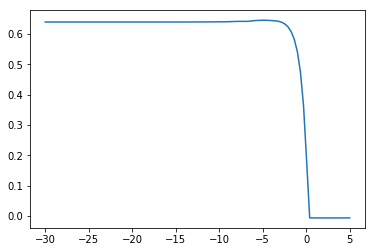

In [12]:
from sklearn.linear_model import Lasso

alphas = np.linspace(-30, 5, 100)
r2s = []
for alpha in alphas:
    res = leave_one_out(X, y, Lasso(alpha=2**alpha))
    r2s.append(r2_score(y, res))
    
plt.plot(alphas, r2s)

best_ind = np.argmax(r2s)
print('best alpha: {}, best R^2 score: {}'.format(2**alphas[best_ind], r2s[best_ind]))

In [14]:
print(Lasso(alpha=2**alphas[best_ind]).fit(X, y).coef_)

[   0.            0.17898532   -0.            0.           -0.23306521
   -0.          118.36749819]


В лучшей моделе используется 3 признака

Подбор параметров для ElasticNet

In [17]:
from sklearn.linear_model import ElasticNet

l1_ratios = np.linspace(0, 1, 50)
alphas = np.linspace(-10, 10, 100)

best_r2 = None
for l1_ratio in l1_ratios:
    for alpha in alphas:
        cur_r2 = r2_score(y, leave_one_out(X, y, ElasticNet(alpha=2**alpha, l1_ratio=l1_ratio)))
        if best_r2 is None or cur_r2 > best_r2:
            best_r2 = cur_r2
            best_l1 = l1_ratio
            best_alpha = alpha
            
print('best R^2 = {}, best l1_ratio = {}, best alpha = {}'.format(best_r2, best_l1, 2**best_alpha))

best R^2 = 0.6453690070167998, best l1_ratio = 1.0, best alpha = 0.03236335646762575


In [18]:
ElasticNet(alpha=2**best_alpha, l1_ratio=best_l1).fit(X, y).coef_

array([   0.        ,    0.17949459,   -0.        ,    0.        ,
         -0.23691864,   -0.        ,  118.48102656])

В лучшей моделе используется 3 признака